<a href="https://colab.research.google.com/github/Kanlaya13/Streamlit/blob/main/FWD101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pygsheets

In [8]:
pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 20.9 MB/s eta 0:00:00


## Import Library and Clean Data

In [9]:
import pygsheets
import google.auth
from google.colab import auth
import warnings
import numpy as np
import re
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import common
from pythainlp.corpus.common import thai_words
from pythainlp import Tokenizer

# set maximum row to unlimit
pd.options.display.max_rows = 999
warnings.filterwarnings('ignore')
auth.authenticate_user() #access google
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

In [10]:
sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/17d_Mw2JR-08A4IsTZIl2zwbW-iVzkhz4GUaatBa92Fo/edit?usp=sharing')
#Get data from google sheet
df_trans = sheet.sheet1.get_as_df()
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    351 non-null    object
 1   source  351 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


In [ ]:
df_trans

In [12]:
data = pd.read_csv('https://raw.githubusercontent.com/baeby0329/scraping_insurance_from_pantip/main/scraping_pantip_tag.csv', index_col=0)
data

,text,source
0,บิ๊กไบค์เกิดอุบัติเหตุเองใบขับขี่หมด 3 ปี ประก...,pantip
1,รถบิ๊คไบค์เกิดอุบัติเหตุเองใบขับขี่หมด 3 ปี ปร...,pantip
2,เป็นนายหน้าประกันวินาศภัยส่งงานเอง กับส่งงานผ่...,pantip
3,เพิ่งสอบผ่านการเป็นนายหน้าประกันวินาศภัยมา และ...,pantip
4,ประกันรถคอก,pantip
...,...,...
2115,"กู้เงิน ธนาคารอนุมัติวงเงินบ้าน4,792,217บาทMRT...",pantip
2116,สินเชื่อซ่อมแซมบ้านบนที่ดินราชพัสดุ,pantip
2117,รบกวนสอบถามผู้รู้ค่ะ ที่บ้านเช่าที่ดินราชพัสดุ...,pantip
2118,นอนรพ.เลยวันที่หมดประกันชดเชยรายได้ สามารถเคลม...,pantip


In [13]:
merged_data = pd.concat([data, df_trans], ignore_index=True)
merged_data

,text,source
0,บิ๊กไบค์เกิดอุบัติเหตุเองใบขับขี่หมด 3 ปี ประก...,pantip
1,รถบิ๊คไบค์เกิดอุบัติเหตุเองใบขับขี่หมด 3 ปี ปร...,pantip
2,เป็นนายหน้าประกันวินาศภัยส่งงานเอง กับส่งงานผ่...,pantip
3,เพิ่งสอบผ่านการเป็นนายหน้าประกันวินาศภัยมา และ...,pantip
4,ประกันรถคอก,pantip
...,...,...
2466,"""อยากได้ประกันIPDแบบไม่ต้องสำรองจ่ายราคาไม่เกิ...",pantip
2467,ทำไมประกันธนชาติห่วยแบบนี้,pantip
2468,เรื่องมีอยู่ว่า เกิดอุบัติเหตุรถยนต์ตัดหน้าเรา...,pantip
2469,ปรึกษาการทำประกันชีวิต TTB,pantip


In [14]:
df = merged_data.drop_duplicates(subset=['text']).reset_index(drop=True)
df = df.dropna(subset=['text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 715
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    715 non-null    object
 1   source  715 non-null    object
dtypes: object(2)
memory usage: 16.8+ KB


## Cluster

In [ ]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

In [16]:
embedder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

corpus = df["text"].tolist()

corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences_3 = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences_3[cluster_id].append(corpus[sentence_id])
    clustered_sentences_3[cluster_id] = [x for x in clustered_sentences_3[cluster_id] if str(x) != 'nan']

for i, cluster in enumerate(clustered_sentences_3):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['เป็นนายหน้าประกันวินาศภัยส่งงานเอง กับส่งงานผ่านโบรกเกอร์ แบบไหนดีกว่า?', 'เพิ่งสอบผ่านการเป็นนายหน้าประกันวินาศภัยมา และกำลังจะเข้ารับการอบรมเพื่อขอใบอนุญาตเป็นนายหน้าฯ แต่ยังไม่รู้ว่าจะส่งงานแบบไหนดี ลองหาข้อมูลในอินเตอร์เน็ต ก็เห็นมีแต่โฆษณาชักชวนให้ส่งผ่านโบรกเกอร์ เลยอยากขอคำแนะนำจากท่านผู้รู้ ว่าควรส่งงานผ่าน บ.ประกันฯโดยตรง หรือผ่านโบรกเกอร์ดี', 'สอบถามหน่อยครับ คือวิ่งรถคอก แล้วจะต่อประกันชั้น2+ประกันเจ้า1บอกว่าจะทำแบบไหน รวมคอกด้วย หรือ ไม่เอาคอกคือผมอยากทราบว่ามันทำได้ด้วยหรอครับ แล้วถ้าทำได้มันมี ผลดี ผลเสีย ต่างกันยังไงครับ(รถผมทำชั้น1รวมคอกอันนี้ทำตอนเปลี่ยนสัญญารถ เจ้าหน้าที่บอกต้องรวมคอก เพราะข้อมูลลงไปในเล่มแล้ว)ขอบคุณครับ', 'ทุกคนมีความคิดเห็นกันยังไงกับประกันรถยนต์แบบเปิดปิดครับ', 'ทั้งเรื่องของความคุ้มครองและความคุ้มค่าขอเหตุผลในการตัดสินใจถ้าเลือกซื้อเป็นตัวนี้ครับตอนนี้เห็นมีของไทยวิวัฒน์ที่น่าสนใจ', 'เรื่องของประกันการเดินทางไปต่างประเทศ มีความจำเป็นมากน้อยแค่ไหนคะ ถ้าซื้อแบบเปิดปิดจะคุ้มไหม', 'ใครเคยทำประกันการเดินทางเปิดปิดของไทยวิวัฒน์รบกวนสอบถามถึ

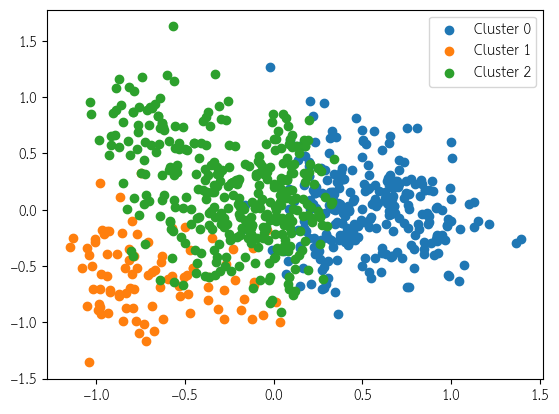

In [17]:
# assume you have a list of sentence embeddings in `embeddings_list`
# and a list of cluster labels in `cluster_labels`
embeddings_list = corpus_embeddings
# convert list to numpy array
embeddings_array = np.array(embeddings_list)

# reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# define color map
cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(len(set(cluster_assignment)))]
# colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'black']

# plot the embeddings in a scatter plot, colored by cluster label
for i, label in enumerate(set(cluster_assignment)):
    indices = np.where(cluster_assignment == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], c=[colors[i]], label=f'Cluster {label}')

plt.legend()
plt.show()

## Word cloud

(-0.5, 3071.5, 2303.5, -0.5)

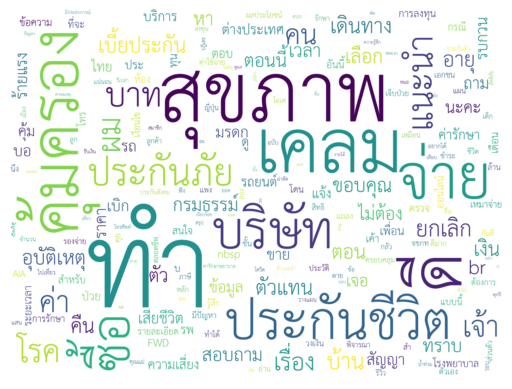

In [18]:
text = ' '.join(clustered_sentences_3[0])
text = ' '.join(word_tokenize(text, engine="newmm"))
stop_word_add = ["ไหม","ได้","การ","มี","หรือ","บ้าง","ครับ","ประกัน","กรรมธรรม์","ปี","เบี้ย"]

wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf',
                      stopwords = list(common.thai_stopwords())+stop_word_add,
                      relative_scaling = 1.0,
                      min_font_size=4,
                      background_color="white",
                      width=1024,
                      height=768,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      margin=2
                      ).generate(text)
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

(-0.5, 3071.5, 2303.5, -0.5)

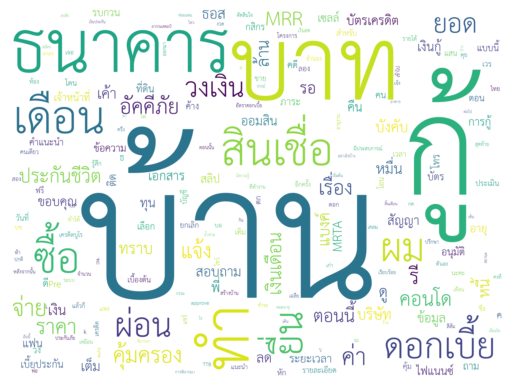

In [19]:
text = ' '.join(clustered_sentences_3[1])
text = ' '.join(word_tokenize(text, engine="newmm"))
stop_word_add = ["ไหม","ได้","การ","มี","หรือ","บ้าง","ครับ","ประกัน","กรรมธรรม์","ปี","เบี้ย"]

wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf',
                      stopwords = list(common.thai_stopwords())+stop_word_add,
                      relative_scaling = 1.0,
                      min_font_size=4,
                      background_color="white",
                      width=1024,
                      height=768,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      margin=2
                      ).generate(text)
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

(-0.5, 3071.5, 2303.5, -0.5)

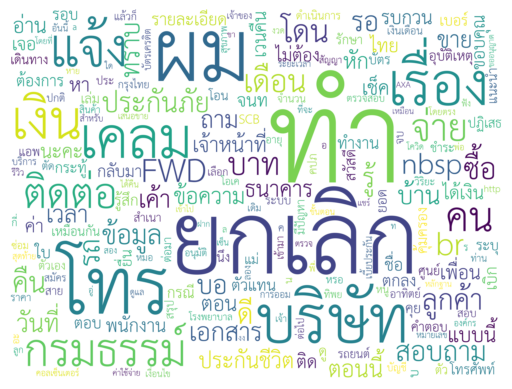

In [20]:
text = ' '.join(clustered_sentences_3[2])
text = ' '.join(word_tokenize(text, engine="newmm"))
stop_word_add = ["ไหม","ได้","การ","มี","หรือ","บ้าง","ครับ","ประกัน","กรรมธรรม์","ปี","เบี้ย"]

wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf',
                      stopwords = list(common.thai_stopwords())+stop_word_add,
                      relative_scaling = 1.0,
                      min_font_size=4,
                      background_color="white",
                      width=1024,
                      height=768,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      margin=2
                      ).generate(text)
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

## Label

### Positive Text

In [21]:
def custom_token(text):
    # Your tokenization logic here
    tokens = custom_tokenizer.word_tokenize(text)
    return tokens

In [22]:
from google.colab import files
uploaded = files.upload()

Saving pos_word_latest.txt to pos_word_latest.txt


In [ ]:
with open('pos_word_latest.txt', 'r') as file:
  pos_txt = file.read()
print(pos_txt)

In [24]:
pos_txt

'รวดเร็ว\nได้ดี\nไม่ผิดหวัง\nโครตดี\nโครตหมาะ\nไม่เคยผิดหวัง\nสบาย\nสนใจ\nฮ่า\nยอดเยี่ยม\nLove\nปลื้มปริ่ม\nถูกใจ\nวู้ว\nได้เลย\nสู้ๆ\nเย้ๆ\nกล้า\nเชี่ยวชาญ\nเด่น\nบวก\nมั่งคั่ง\nมั่งมี\nรอบคอบ\nเร็ว\nละเอียด\nละมุน\nละมุนละม่อม\nสำเร็จ\nสุภาพ\nหนุ่มแน่น\nอร่อย\nใหญ่โต\nอ่อนโยน\nอัศจรรย์\nเฮง\nดี\nดีใจ\nอุ่นใจ\nเข้าตา\nเข้าตากรรมการ\nรัก\nชอบ\nงดงาม\nกตเวที\nกตัญญู\nแข็งแกร่ง\nแข็งขัน\nแข็งแรง\nครื้นครึก\nครึกครื้น\nแจ่ม\nแจ่มใส\nชัดเจน\nชัดแจ้ง\nชัดแจ๋ว\nชัดถ้อยชัดคำ\nชุ่มชื้น\nหวาน\nน่ารื่นรมย์\nน่ารัก\nเบาใจ\nฉลาด\nอบอุ่น\nความสุข\nสุข\nประทับใจ\nซาบซึ้ง\nตงฉิน\nภูมิใจ\nมหัศจรรย์ใจ\nมีความรู้\nมีความยินดี\nเบิกบาน\nที่เชื่อถือได้\nผ่องใส\nเพราพริ้ง\nเพราเพริศ\nเพริศแพร้ว\nเพริศพราย\nเพา\nยอดเยี่ยม\nเยี่ยม\nเยี่ยมยอด\nรจนา\nโดดเด่น\nรุ่ง\nรุ่งเรือง\nรุ่งโรจน์\nทันสมัย\nล้ำเลิศ\nลึกซึ้ง\nเสถียรภาพ\nเพลิดเพลิน\nน่านับถือ\nสดใส\nสบาย\nสมจริง\nสมบูรณ์\nสร้างสรรค์\nสวย\nสวยงาม\nสห\nสะดวก\nสะอาด\nสัณห์\nสุขี\nสูงส่ง\nเหมาะเจาะ\nเหมาะสม\nมีประโยชน์\nมีเหตุผล\nมีชีวิตชีวา\nมีชื่อ\nมีชื่อเสีย

In [25]:
pos_list = pos_txt.splitlines()
pos_list = [pos.strip() for pos in pos_list]
pos_list = list(filter(bool, pos_list))
pos_list

['รวดเร็ว',
 'ได้ดี',
 'ไม่ผิดหวัง',
 'โครตดี',
 'โครตหมาะ',
 'ไม่เคยผิดหวัง',
 'สบาย',
 'สนใจ',
 'ฮ่า',
 'ยอดเยี่ยม',
 'Love',
 'ปลื้มปริ่ม',
 'ถูกใจ',
 'วู้ว',
 'ได้เลย',
 'สู้ๆ',
 'เย้ๆ',
 'กล้า',
 'เชี่ยวชาญ',
 'เด่น',
 'บวก',
 'มั่งคั่ง',
 'มั่งมี',
 'รอบคอบ',
 'เร็ว',
 'ละเอียด',
 'ละมุน',
 'ละมุนละม่อม',
 'สำเร็จ',
 'สุภาพ',
 'หนุ่มแน่น',
 'อร่อย',
 'ใหญ่โต',
 'อ่อนโยน',
 'อัศจรรย์',
 'เฮง',
 'ดี',
 'ดีใจ',
 'อุ่นใจ',
 'เข้าตา',
 'เข้าตากรรมการ',
 'รัก',
 'ชอบ',
 'งดงาม',
 'กตเวที',
 'กตัญญู',
 'แข็งแกร่ง',
 'แข็งขัน',
 'แข็งแรง',
 'ครื้นครึก',
 'ครึกครื้น',
 'แจ่ม',
 'แจ่มใส',
 'ชัดเจน',
 'ชัดแจ้ง',
 'ชัดแจ๋ว',
 'ชัดถ้อยชัดคำ',
 'ชุ่มชื้น',
 'หวาน',
 'น่ารื่นรมย์',
 'น่ารัก',
 'เบาใจ',
 'ฉลาด',
 'อบอุ่น',
 'ความสุข',
 'สุข',
 'ประทับใจ',
 'ซาบซึ้ง',
 'ตงฉิน',
 'ภูมิใจ',
 'มหัศจรรย์ใจ',
 'มีความรู้',
 'มีความยินดี',
 'เบิกบาน',
 'ที่เชื่อถือได้',
 'ผ่องใส',
 'เพราพริ้ง',
 'เพราเพริศ',
 'เพริศแพร้ว',
 'เพริศพราย',
 'เพา',
 'ยอดเยี่ยม',
 'เยี่ยม',
 'เยี่ยมยอด',
 'รจนา',
 'โดดเด่น'

### Negative Text

In [26]:
from google.colab import files
uploaded = files.upload()

Saving neg_word_latest.txt to neg_word_latest.txt


In [ ]:
with open('neg_word_latest.txt', 'r') as file:
  neg_txt = file.read()
print(neg_txt)

In [28]:
neg_txt

'ท้อแท้\nเครียด\nเยสเเม่\nหดหู่\nเเรงกดดัน\nอิเวนน\nร้องไห้\nบั่นทอน\nใจหมา\nชาติหมา\nสันดานหมา\nปากหมา\nร้องไห้\nอึดอัด\nรำคาญ\nโครต\nอย่า\nหลอกลวง\nต้มตุ๋น\nปลอม\nตำหนิ\nไปสบายเเล้ว\nไม่ชอบ\nไม่ดี\nโง่เง่า\nRIP\nตีน\nอิดอก\nหน้าหมี\nโดนหลอก\nหลอกลวง\nสาปส่ง\nเหม็น\nบัดซบ\nแย่\nอันตราย\nเสียชีวิต\nความเสียใจ\nตายห่า\nแข็งกระด้าง\nชุ่ย\nห่วยแตก\nแม่เยส\nเฟล\nเยสเข้\nสถุน\nไม่ชอบ\nปวดหัว\nเสียหมา\nเวรกรรม\nลงโทษ\nท้องเสีย\nหัวดอ\nอิเวน\nเอาตาย\nโอดโอย\nน่าเกลียด\nอาชญากรรม\nความขมขื่น\nความขมุกขมัว\nความขุ่นเคือง\nความข้องใจ\nความฉิบหาย\nความชั่วช้า\nวิกฤติ\nเจ็บปวด\nเผด็จการ\nขัดแย้ง\nรังเกียจ\nไร้สาระ\nน่าเบื่อ\nงอแง\nต่ำ\nซวย\nปรัมปรา\nฉุนเฉียว\nเฉื่อย\nผิดหวัง\nโมเม\nล้าสมัย\nลำบาก\nหงุดหงิด\nบรรลัย\nไม่เจียมกะลาหัว\nไม่เอาไหน\nไม่ได้เรื่อง\nทุจริต\nไอ้เวร\nไอ้บ้า\nถุย\nรุม\nชั่งแม่ง\nแม่ง\nมั่ว\nมั่วซั่ว\nมั่วนิ่ม\nขี้โม้\nโกง\nเซ็ง\nละเหี่ยใจ\nอีห่า\nเสแสร้ง\nพังพินาศ\nย่ำแย่\nแย่จัง\nแย่มาก\nไม่ดี\nหมดค่า\nฆ่า\nข่ม\nข่มขืน\nขโมย\nตาย\nเสียใจ\nกดดัน\nกดขี่\nกระทืบ\nก่อกวน\nก่อกรรม

In [29]:
neg_list = neg_txt.splitlines()
neg_list = [neg.strip() for neg in neg_list]
neg_list = list(filter(bool, neg_list))
neg_list

['ท้อแท้',
 'เครียด',
 'เยสเเม่',
 'หดหู่',
 'เเรงกดดัน',
 'อิเวนน',
 'ร้องไห้',
 'บั่นทอน',
 'ใจหมา',
 'ชาติหมา',
 'สันดานหมา',
 'ปากหมา',
 'ร้องไห้',
 'อึดอัด',
 'รำคาญ',
 'โครต',
 'อย่า',
 'หลอกลวง',
 'ต้มตุ๋น',
 'ปลอม',
 'ตำหนิ',
 'ไปสบายเเล้ว',
 'ไม่ชอบ',
 'ไม่ดี',
 'โง่เง่า',
 'RIP',
 'ตีน',
 'อิดอก',
 'หน้าหมี',
 'โดนหลอก',
 'หลอกลวง',
 'สาปส่ง',
 'เหม็น',
 'บัดซบ',
 'แย่',
 'อันตราย',
 'เสียชีวิต',
 'ความเสียใจ',
 'ตายห่า',
 'แข็งกระด้าง',
 'ชุ่ย',
 'ห่วยแตก',
 'แม่เยส',
 'เฟล',
 'เยสเข้',
 'สถุน',
 'ไม่ชอบ',
 'ปวดหัว',
 'เสียหมา',
 'เวรกรรม',
 'ลงโทษ',
 'ท้องเสีย',
 'หัวดอ',
 'อิเวน',
 'เอาตาย',
 'โอดโอย',
 'น่าเกลียด',
 'อาชญากรรม',
 'ความขมขื่น',
 'ความขมุกขมัว',
 'ความขุ่นเคือง',
 'ความข้องใจ',
 'ความฉิบหาย',
 'ความชั่วช้า',
 'วิกฤติ',
 'เจ็บปวด',
 'เผด็จการ',
 'ขัดแย้ง',
 'รังเกียจ',
 'ไร้สาระ',
 'น่าเบื่อ',
 'งอแง',
 'ต่ำ',
 'ซวย',
 'ปรัมปรา',
 'ฉุนเฉียว',
 'เฉื่อย',
 'ผิดหวัง',
 'โมเม',
 'ล้าสมัย',
 'ลำบาก',
 'หงุดหงิด',
 'บรรลัย',
 'ไม่เจียมกะลาหัว',
 'ไม่เอาไหน',
 'ไม่

### tokenize

In [30]:
words = set(thai_words())  # thai_words() returns frozenset
words.update(neg_list)
words.update(pos_list)
custom_tokenizer = Tokenizer(words)

In [34]:
df = df.copy()
df['tokens'] = df['text'].apply(custom_token)
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))
df.sample(10)

,text,source,tokens
107,สินม….ง ประกันภัยรถยนต์ รีวิวประกัน ประกันภัยท...,pantip,สิ นม ….ง ประกันภัย รถยนต์ รีวิว ประกัน ...
234,สงสัยการแถลงสุขภาพประกันค่ะ,pantip,สงสัย การแถลง สุขภาพ ประกัน ค่ะ
506,เรากู้ซื้อบ้านในราคา 5 ล้าน บาทค่ะ กู้ร่วมกับแ...,pantip,เรา กู้ ซื้อ บ้าน ใน ราคา 5 ล้าน บาท ค่ะ...
248,เริ่มซื้อประกันชีวิตครั้งแรก,pantip,เริ่ม ซื้อ ประกันชีวิต ครั้งแรก
631,"<img class=""img-in-post"" src=""https://f.ptcdn....",pantip (fwd),"< img class ="" img-in-post "" src ="" https ..."
460,พอดีเรากู้บ้านคาะของ ธอส ใช้สวัสดิการกู้ค่ะ กำ...,pantip,พอดี เรา กู้ บ้าน คา ะ ของ ธอส ใช้ สวัสดิ ...
357,จะยกเลิก ประกัน ของ ชับบ์สามัคคี คับ,pantip,จะ ยกเลิก ประกัน ของ ชับบ์ สามัคคี คับ
141,เคลมทิพยะประกันภัย,pantip,เคลม ทิพ ยะ ประกันภัย
240,ไทยประกันชีวิตทำไว้แบบ15ปีแบบมีปันผลจะครบกำหนด...,pantip,ไทย ประกันชีวิต ทำ ไว้ แบบ 15 ปี แบบ มี ปันผล ...
588,ดูวันที่ในหนังสือรับรองการชำระเบี้ยครับ หัวจะม...,pantip,ดู วันที่ ใน หนังสือรับรอง การ ชำระ เบี้ย ครับ...


In [35]:
pattern = '|'.join(neg_list)
result = df[df['text'].str.contains(pattern, regex=True, flags=re.IGNORECASE)]
result.sample(10)

,text,source,tokens
142,แจ้งเคลมวันที่9 ธ.ค.65วันนี้ 13 มค.66 (ในแบบฟอ...,pantip,แจ้ง เคลม วันที่ 9 ธ.ค. 65 วันนี้ 13 มค....
309,สืบเนื่องจากประกัน TQM โทรมาทุกวันค่ะ เราก็รับ...,pantip,สืบ เนื่องจาก ประกัน TQM โทร มา ทุกวัน ค่ะ...
697,",เราซื้อประกันสุขภาพเจ้านี้อยู่ชื่อซันเดย์ล่าส...",pantip,", เรา ซื้อ ประกัน สุขภาพ เจ้า นี้ อยู่ ชื่อ ซั..."
562,ความคิดเห็นนี้ถูกลบเนื่องจาก มีเนื้อหาเสนอซื้อ...,pantip,ความคิดเห็น นี้ ถู กลบ เนื่องจาก มี เนื้อหา ...
469,ยื่นกู้บ้าน ธอส. จะผ่านไหมน้อ,pantip,ยื่น กู้ บ้าน ธอส. จะ ผ่าน ไหม น้อ
359,ต้องการยกเลิกการส่งประกันชีวิตหรือเวรคืน ของ A...,pantip,ต้องการ ยกเลิก การ ส่ง ประกันชีวิต หรือ เวร คื...
156,ผมจะทำการรีไฟแนนซ์บ้าน ทีนี้ตัวประกันอัคคีภัยผ...,pantip,ผม จะ ทำการ รี ไฟแนนซ์ บ้าน ทีนี้ ตัวประกัน ...
384,ใครเคยเคลมค่าคลอดบุตรกับประกัน LMG บ้างครับ,pantip,ใคร เคย เคลม ค่า คลอด บุตร กับ ประกัน LMG ...
458,แชร์ประสบการณ์ค่ะเนื่องด้วยเราได้กู้บ้านหลังแร...,pantip,แชร์ ประสบการณ์ ค่ะ เนื่องด้วย เรา ได้ กู้ บ้า...
165,เราทำประกันภัยน้ำท่วมบ้านเปี่ยมสุข กับบริษัทวิ...,pantip,เรา ทำ ประกันภัย น้ำท่วม บ้าน เปี่ยม สุข กับ...


In [36]:
# Function to check if any toxic word is contained in the tokens
def check_toxic_words(tokens):
    return [word for word in tokens.split() if word in neg_list]
def count_toxic_words(tokens):
    count = sum([1 for word in tokens.split() if word in neg_list])
    return count

def check_pos_words(tokens):
    return [word for word in tokens.split() if word in pos_list]
def count_pos_words(tokens):
    count = sum([1 for word in tokens.split() if word in pos_list])
    return count

# check for toxic words
df['ToxicWordCount'] = df['tokens'].apply(count_toxic_words)
df['ToxicWords'] = df['tokens'].apply(check_toxic_words)
# check for positive words
df['PosWordCount'] = df['tokens'].apply(count_pos_words)
df['PosWords'] = df['tokens'].apply(check_pos_words)

df.sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords
409,หาซื้อประกันAIAกับเมืองไทยใครเป็นตัวแทนทักมาให...,pantip,หา ซื้อ ประกัน AIA กับ เมือง ไทย ใคร เป็นตัวแท...,0,[],0,[]
306,กำลังจะต่อประกันรถยนต์ลองถามประกันออนไลน์เจ้าต...,pantip,กำลังจะ ต่อ ประกัน รถยนต์ ลอง ถาม ประกัน ออนไล...,1,[โกง],0,[]
419,อยากได้ประกันIPDแบบไม่ต้องสำรองจ่ายราคาไม่เกิน...,pantip,อยากได้ ประกัน IPD แบบ ไม่ต้อง สำ รองจ่าย ราคา...,0,[],0,[]
302,ประกันสุขภาพตัวไหนดี ตั้งงบไม่เกินปีละ 24000 บาท,pantip,ประกัน สุขภาพ ตัว ไหน ดี ตั้ง งบ ไม่ เกิน ป...,0,[],1,[ดี]
125,เคลมประกันบ้านน้ำท่วมทิพยประกันภัย,pantip,เคลม ประกัน บ้าน น้ำท่วม ทิพย ประกันภัย,0,[],0,[]


In [65]:
df['label_token'] = np.select(
    [(df['ToxicWordCount'] > 0),
     (df['PosWordCount'] > 0) & (df['ToxicWordCount'] == 0)],
    ['neg', 'pos'], default='neu')

df.sample(10)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,label_token
130,คืออยากถามผู้มีประสบการณ์ว่า มีใครที่ยื่นแล้ว ...,pantip,คือ อยาก ถาม ผู้ มีประสบการณ์ ว่า มี ใคร ที่...,0,[],0,[],neu
215,เราเพิ่งทำ ilink (unit linked) ของ axa ไปได้ 6...,pantip,เรา เพิ่ง ทำ ilink ( unit linked ) ของ...,0,[],0,[],neu
353,เตือนภัย ! ใครคิดจะทำประกัน วิริยะ By bdmh ต้อ...,pantip,เตือนภัย ! ใคร คิด จะ ทำ ประกัน วิริยะ ...,0,[],0,[],neu
518,สินเชื่อซ่อมแซมบ้านบนที่ดินราชพัสดุ,pantip,สินเชื่อ ซ่อมแซม บ้าน บน ที่ดิน ราช พัสดุ,0,[],0,[],neu
663,ทักหลังไมค์​เรียบร้อย​ อ่อ​ บ่ายเข้าไปสะสมเพิ่...,pantip (fwd),ทัก หลัง ไมค์ ​ เรียบร้อย ​ อ่อ​ บ่าย เข้า...,3,"[โกง, อย่า, โกง]",0,[],neg
15,เรื่องประกันการเดินทางต่างประเทศ คือถ้ากำหนดขอ...,pantip,เรื่อง ประกัน การ เดินทาง ต่างประเทศ คือ ถ้า...,0,[],0,[],neu
551,ตอนนเรานอยมาก แฟนเราเค้ามีคนอื่นแต่เค้าบอกว่าเ...,pantip,ตอน น เรา นอ ย มาก แฟน เรา เค้า มี คนอื่น แต...,0,[],1,[ชอบ],pos
18,มีประกัน AXA อยู่แล้ว ไปต่างประเทศต้องซื้อเพิ่...,pantip,มี ประกัน AXA อยู่แล้ว ไป ต่างประเทศ ต้อ...,0,[],0,[],neu
7,ตอนแรกมีเบอร์แปลกโทรหาผม แต่ Whocall ไม่แจ้งว่...,pantip,ตอนแรก มี เบอร์ แปลก โทร หา ผม แต่ Whocall...,0,[],1,[สำเร็จ],pos
344,ยกเลิกประกันบริษัท chubb ยากมาก !,pantip,ยกเลิก ประกัน บริษัท chubb ยาก มาก !,0,[],0,[],neu


In [68]:
df[df['label_token'] == 'pos'].sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,label_token
643,ชอบพูดไม่ครบ,pantip (fwd),ชอบ พูด ไม่ ครบ,0,[],1,[ชอบ],pos
64,รบกวนสอบถามค่ะตอนนี้เวลาไปเกาหลีเราต้องทำประกั...,pantip,รบกวน สอบถาม ค่ะ ตอนนี้ เวลา ไป เกาหลี เรา ต้อ...,0,[],1,[ดี],pos
490,รายละเอียดของผมคือ เงินผมที่ได้จากการขายของเนี...,pantip,รายละเอียด ของ ผม คือ เงิน ผม ที่ ได้ จาก กา...,0,[],4,"[ชัดเจน, ดี, ดี, ดี]",pos
323,มาแบบเดียวกับ 9 สิงห์โบรคเกอร์ เลย คำพูดเดียวก...,pantip,มา แบบ เดียว กับ 9 สิงห์ โบ รคเกอร์ เลย ...,0,[],1,[ดี],pos
244,ประกันชีวิตบริษัทไหนดีครับ,pantip,ประกันชีวิต บริษัท ไหน ดี ครับ,0,[],1,[ดี],pos


In [67]:
df[df['label_token'] == 'neg'].sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,label_token
715,เรื่องมีอยู่ว่า เกิดอุบัติเหตุรถยนต์ตัดหน้าเรา...,pantip,เรื่อง มี อยู่ ว่า เกิด อุบัติเหตุ รถยนต์ ตั...,3,"[ห่วย, ไอ้, ห่วย]",0,[],neg
291,พอดีเราสมัครงาน เป็นพนักงานขายประกันของTQM ผมอ...,pantip,พอดี เรา สมัครงาน เป็น พนักงานขาย ประกัน ของ...,2,"[กดดัน, ด่า]",0,[],neg
74,ประกันภัยอุบัติเหตุส่วนบุคคลPAโดยสารรถจักรยานย...,pantip,ประกันภัย อุบัติเหตุ ส่วนบุคคล PA โดยสาร รถจัก...,3,"[เสียชีวิต, เสียชีวิต, เสียชีวิต]",1,[ดี],neg
506,เรากู้ซื้อบ้านในราคา 5 ล้าน บาทค่ะ กู้ร่วมกับแ...,pantip,เรา กู้ ซื้อ บ้าน ใน ราคา 5 ล้าน บาท ค่ะ...,1,[เวร],0,[],neg
122,ใครเคยเคลมประกันบ้านของกรุงเทพประกันภัยบ้างคะ?...,pantip,ใคร เคย เคลม ประกัน บ้าน ของ กรุงเทพ ประกันภัย...,1,[ผิดหวัง],1,[ดี],neg


### contains

In [61]:
df1 = df.copy()
df1['contains_toxic_word'] = df1['text'].str.contains('|'.join(neg_list))
df1['contains_pos_word'] = df['text'].str.contains('|'.join(pos_list))

df1.sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,contains_toxic_word,contains_pos_word
320,[CR] Insurepaws บริษัทประกันสัตว์เลี้ยงห่วยๆ,pantip,[ CR ] Insurepaws บริษัท ประกัน สัตว์เลี้ย...,1,[ห่วย],0,[],True,False
256,"ทำประกันสุขภาพ อาชีพขั้น 1,2",pantip,"ทำ ประกัน สุขภาพ อาชีพ ขั้น 1,2",0,[],0,[],False,True
625,\n\t\t\t\t\t\t\t\tพอดีทำประกันกับ FWD ไว้และต้...,pantip (fwd),\n \t\t\t\t\t\t\t\t พอดี ทำ ประกัน กับ FWD ...,0,[],0,[],True,True
632,คำพูดเซลเชื่อไม่ได้ต้องมีหลักฐาน,pantip (fwd),คำพูด เซ ล เชื่อ ไม่ ได้ ต้อง มี หลักฐาน,0,[],0,[],False,False
570,สวัสดีค่ะเพิ่งทำได้3เดือนแต่อยากยกเลิกไม่ไหวส่...,pantip,สวัสดี ค่ะ เพิ่ง ทำได้ 3 เดือน แต่ อยาก ยกเลิก...,0,[],0,[],False,True


In [62]:
df1['label_contain'] = np.select(
    [(df1['contains_toxic_word'] == True),
     (df1['contains_pos_word'] == True) & (df1['contains_toxic_word'] == False)],
    ['neg', 'pos'], default='neu')

df1.sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,contains_toxic_word,contains_pos_word,label_contain
705,สวัสดีค่ะ เราเป็น1ในทีมพยาบาลที่ทำงานเกี่ยวกับ...,pantip,สวัสดี ค่ะ เรา เป็น 1 ใน ทีม พยาบาล ที่ทำงาน...,0,[],1,[เร็ว],True,True,neg
186,ประกันชีวิตเกี่ยวกับโรคร้ายแรง บริษัทไหนดี บ้า...,pantip,ประกันชีวิต เกี่ยวกับ โรค ร้ายแรง บริษัท ไหน...,0,[],1,[ดี],True,True,neg
53,ประกันรถยนตฺที่คุ้มครองคู่กรณี ควรทำอันไหนดีคะ,pantip,ประกัน รถ ยนตฺ ที่ คุ้มครอง คู่กรณี ควร ทำ อ...,0,[],1,[ดี],False,True,pos
267,บ้านเรา ทุกคนมีต้นทุนในการดูแลความปลอดภัยของชี...,pantip,บ้าน เรา ทุกคน มี ต้นทุน ใน การ ดูแล ความปลอ...,0,[],1,[ดี],True,True,neg
287,หนีจากกลุ่มขายประกันมาเพราะไม่อยากคุยกับพวกตัว...,pantip,หนี จาก กลุ่ม ขาย ประกัน มา เพราะ ไม่ อยาก คุย...,0,[],1,[ดี],True,True,neg


In [69]:
df1[df1['label_contain'] == 'neu'][['contains_toxic_word', 'contains_pos_word', 'label_contain']]
df1.sample(5)

,text,source,tokens,ToxicWordCount,ToxicWords,PosWordCount,PosWords,contains_toxic_word,contains_pos_word,label_contain
52,อยากสอบถามผู้รู้ว่าสามารถยกเลิกได้ที่ไหนครับ พ...,pantip,อยาก สอบถาม ผู้รู้ ว่า สามารถ ยกเลิก ได้ ที่ไห...,0,[],0,[],False,True,pos
331,อยากทราบว่า ทางบริษัทส่ง sms มาแจ้งแบบนี่ ถือเ...,pantip,อยาก ทราบ ว่า ทาง บริษัท ส่ง sms มา แจ้ง...,0,[],0,[],False,False,neu
577,ปัจจุบันนี้ประกันมีหลายแบบและหลายบริษัท ส่วนให...,pantip,ปัจจุบันนี้ ประกัน มี หลาย แบบ และ หลาย บริษัท...,0,[],0,[],True,True,neg
88,ตามหัวข้อเลยค่ะ เรากำลังจะพาทีมในออฟฟิศ 7 คน ไ...,pantip,ตาม หัวข้อ เลย ค่ะ เรา กำลังจะ พา ทีม ใน ออฟ...,0,[],1,[ดี],True,True,neg
383,สามารถใช้สิทธิบัตรทองได้ไหมคะ,pantip,สามารถ ใช้ สิทธิบัตร ทอง ได้ ไหม คะ,0,[],0,[],False,False,neu


## Tokenize and Contain

### Graph Tokens

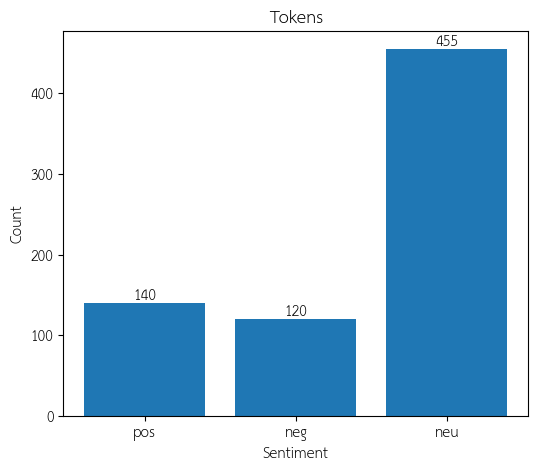

In [117]:
# Graph Tokens
label_counts = df['label_token'].value_counts()

label_counts = label_counts.reindex(['pos', 'neg', 'neu'])

plt.figure(figsize=(6, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Tokens')

for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

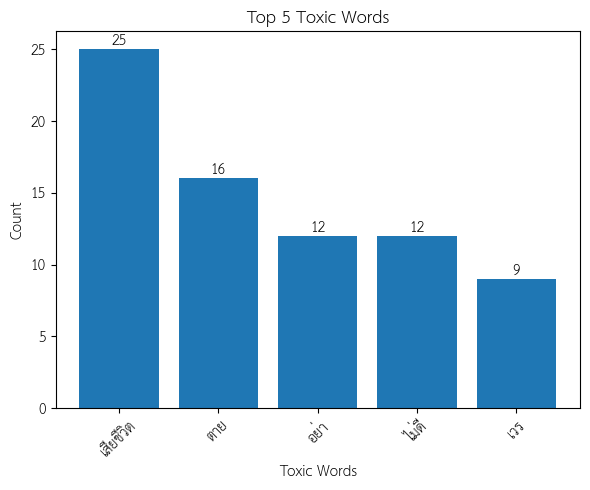

In [124]:
# Negative Words พบบ่อย 5 คำ
df_neg = df[df['label_token'] == 'neg']


top_neg_words = df_neg['ToxicWords'].explode().value_counts().head(5)


plt.figure(figsize=(6, 5))
plt.bar(top_neg_words.index, top_neg_words.values)
plt.xlabel('Toxic Words')
plt.ylabel('Count')
plt.title('Top 5 Toxic Words')

plt.xticks(rotation=45)

for i, count in enumerate(top_neg_words.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


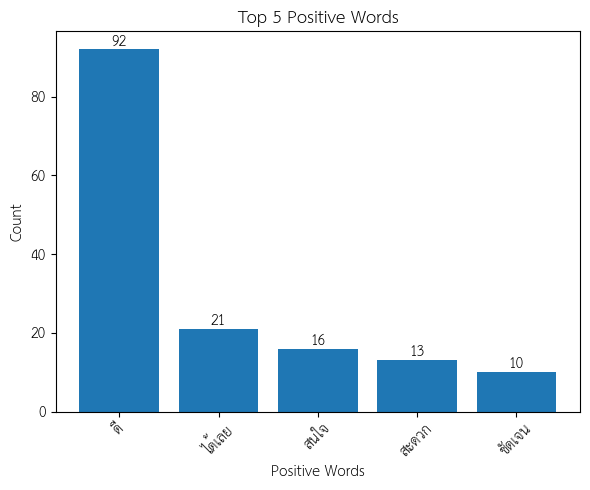

In [120]:
# Top 5 Positive Words
df_neg = df[df['label_token'] == 'pos']

top_neg_words = df_neg['PosWords'].explode().value_counts().head(5)

plt.figure(figsize=(6, 5))
plt.bar(top_neg_words.index, top_neg_words.values)
plt.xlabel('Positive Words')
plt.ylabel('Count')
plt.title('Top 5 Positive Words')

plt.xticks(rotation=45)

for i, count in enumerate(top_pos_words.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [98]:
df.columns

Index(['text', 'source', 'tokens', 'ToxicWordCount', 'ToxicWords',
       'PosWordCount', 'PosWords', 'label_token'],
      dtype='object')

### Graph Contains

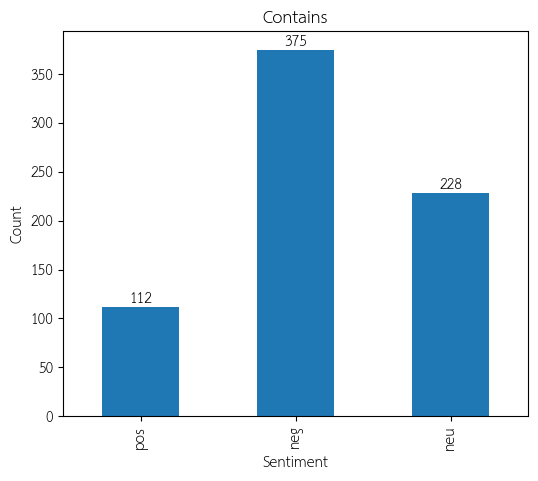

In [113]:
# Graph Contains
label_counts = df1['label_contain'].value_counts()

label_counts = label_counts.reindex(['pos', 'neg', 'neu'])

plt.figure(figsize=(6, 5))
label_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Contains')

for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [91]:
df1.columns

Index(['text', 'source', 'tokens', 'ToxicWordCount', 'ToxicWords',
       'PosWordCount', 'PosWords', 'contains_toxic_word', 'contains_pos_word',
       'label_contain'],
      dtype='object')

### Tokenize VS Contains

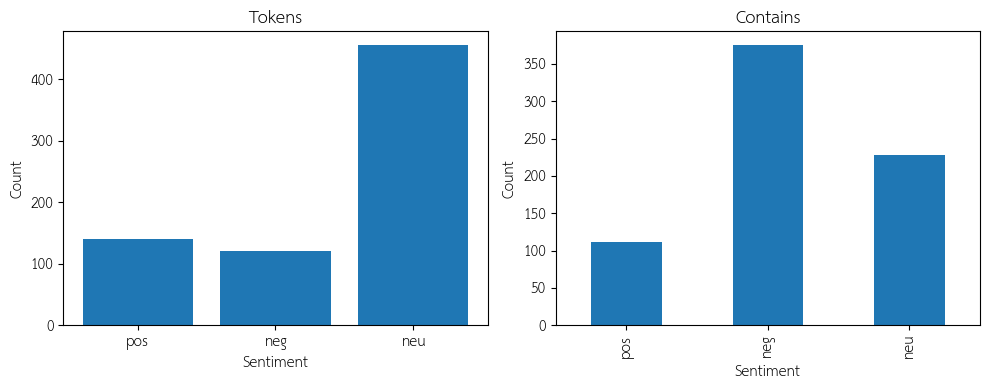

In [112]:
# Tokenize and Contains
label_counts_token = df['label_token'].value_counts().reindex(['pos', 'neg', 'neu'])
label_counts_contain = df1['label_contain'].value_counts().reindex(['pos', 'neg', 'neu'])


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(label_counts_token.index, label_counts_token.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Tokens')

plt.subplot(1, 2, 2)
label_counts_contain.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Contains')

plt.tight_layout()
plt.show()

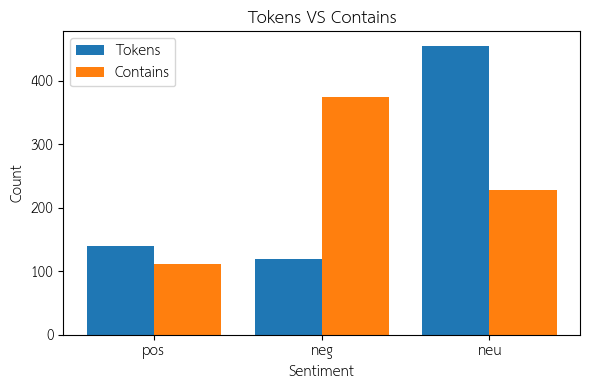

In [111]:
# Tokenize VS Contains
fig, ax = plt.subplots(figsize=(6, 4))

label_counts_token = df['label_token'].value_counts().reindex(['pos', 'neg', 'neu'])
label_counts_contain = df1['label_contain'].value_counts().reindex(['pos', 'neg', 'neu'])

ax.bar(label_counts_token.index, label_counts_token.values, width=0.4, label='Tokens')

ax.bar(np.arange(len(label_counts_contain.index)) + 0.4, label_counts_contain.values, width=0.4, label='Contains')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Tokens VS Contains')
ax.set_xticks(np.arange(len(label_counts_token.index)) + 0.2)
ax.set_xticklabels(label_counts_token.index)
ax.legend()

plt.tight_layout()
plt.show()
